In [1]:
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from scipy.stats import ttest_1samp
import pandas as pd
import numpy as np
import dabest
import os

from util.preprocessing import calc_overest_means
from util.simulation import DataSimulator

In [2]:
N_SUBJECTS = 80
ALPHA_MAIN = .01
ALPHA_INTER = .05
CONVERT_TO_MS = False # set to true if data given in seconds

In [3]:
# simulate data under alternative hypothesis
sim = DataSimulator()
rng = np.random.default_rng(0)
dfs = [sim.simulate_subject(1, rng) for sub in range(N_SUBJECTS)]

In [4]:
# calculate the mean estimation error in each condition
means = [calc_overest_means(df) for df in dfs]
df = pd.DataFrame(means)
df.head()

,masked baseline,masked operant,unmasked baseline,unmasked operant
0,-8.745906,39.205659,0.118022,42.470662
1,2.273678,-33.239828,-2.331001,-49.122566
2,3.166564,89.161283,-12.358447,89.292375
3,-35.100000,-44.210132,-0.451287,-48.249835
4,15.512737,90.072252,-2.199832,79.967687


In [5]:
# compute paired differences
delta_masked = df['masked operant'] - df['masked baseline']
delta_unmasked = df['unmasked operant'] - df['unmasked baseline']
delta2 = delta_masked - delta_unmasked

In [6]:
# test for main effect of interest
res = ttest_1samp(delta_masked, popmean = 0, alternative = 'greater')
rej_masked = res.pvalue < ALPHA_MAIN
w = '' if rej_masked else ' not'
result = 'Null hypothesis%s rejected with t(%d) = %.03f, p = %f'%(
    w, N_SUBJECTS - 1, res.statistic, res.pvalue)
print(result)

Null hypothesis rejected with t(79) = 4.857, p = 0.000003


In [7]:
# test for interaction effect
res = ttest_1samp(delta2, popmean = 0, alternative = 'less')
rej_interaction = res.pvalue < ALPHA_INTER # use nominal alpha, not adjusted
w = '' if rej_interaction else ' not'
result = 'Null hypothesis%s rejected with t(%d) = %.03f, p = %f'%(
    w, N_SUBJECTS - 1, res.statistic, res.pvalue)
print(result)

Null hypothesis not rejected with t(79) = 1.024, p = 0.845548


In [8]:
def tidy_dataframe(df):
    dfs = []
    for cond in df.columns:
        masked, operant = cond.split(' ')
        df_cond = df[[cond]].copy()
        df_cond.insert(0, column = 'subject', value = df_cond.index)
        df_cond.insert(0, column = 'operant', value = operant)
        df_cond.insert(0, column = 'masked', value = masked)
        df_cond.insert(0, column = 'condition', value = cond)
        df_cond.columns = [
            'condition', 'masked', 'type', 'subject', 'estimation error (ms)'
        ]
        dfs.append(df_cond)
    tidy_df = pd.concat(dfs, ignore_index = True)
    if CONVERT_TO_MS:
        tidy_df['estimation error (ms)'] *= 1000.
    return tidy_df

tidy_df = tidy_dataframe(df)
tidy_df.head()

,condition,masked,type,subject,estimation error (ms)
0,masked baseline,masked,baseline,0,-8.745906
1,masked baseline,masked,baseline,1,2.273678
2,masked baseline,masked,baseline,2,3.166564
3,masked baseline,masked,baseline,3,-35.100000
4,masked baseline,masked,baseline,4,15.512737


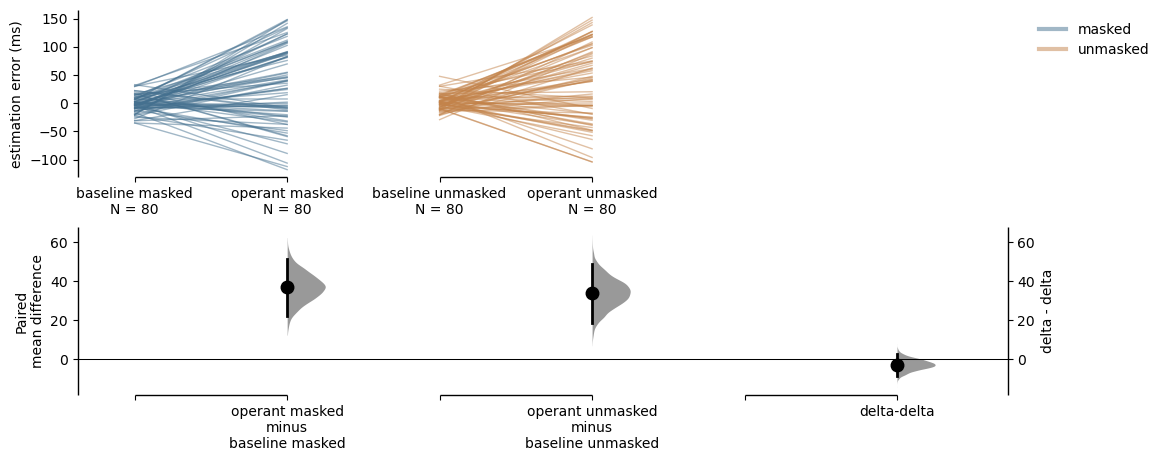

In [9]:
data = dabest.load(
    data = tidy_df, 
    x = ['type', 'masked'], y = 'estimation error (ms)', 
    id_col = 'subject',
    paired = 'baseline',
    experiment = 'masked',
    delta2 = True,
    random_seed = 0
)
data.mean_diff.plot(fig_size = (12, 5))
plt.show()

In [10]:
# confidence intervals for paired standard effect sizes
data.cohens_d.results[['difference', 'ci', 'bca_low', 'bca_high', 'resamples']]

,difference,ci,bca_low,bca_high,resamples
0,0.739618,95,0.408662,1.065388,5000
1,0.697865,95,0.363594,1.033558,5000


In [11]:
# confidence intervals for paired effect sizes in milliseconds
data.mean_diff.results[['difference', 'ci', 'bca_low', 'bca_high', 'resamples']]

,difference,ci,bca_low,bca_high,resamples
0,36.856085,95,21.993696,51.436490,5000
1,33.917981,95,18.244063,48.820965,5000


In [12]:
# confidence interval for difference-in-difference
data.mean_diff.delta_delta

DABEST v2023.02.14
                  
Good afternoon!
The current time is Sat Sep 16 14:35:44 2023.

The delta-delta between masked and unmasked is -2.94 [95%CI -8.68, 2.57].
The p-value of the two-sided permutation t-test is 0.319, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing the effect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

In [13]:
## simulate more data under null hypothesis
dfs = [sim.simulate_subject(0, rng) for sub in range(N_SUBJECTS)]
means = [calc_overest_means(df) for df in dfs]
null_df = pd.DataFrame(means)
null_tidy_df = tidy_dataframe(null_df)
null_data = dabest.load(
    data = null_tidy_df, 
    x = ['type', 'masked'], y = 'estimation error (ms)', 
    id_col = 'subject',
    paired = 'baseline',
    experiment = 'masked',
    delta2 = True,
    random_seed = 1
)

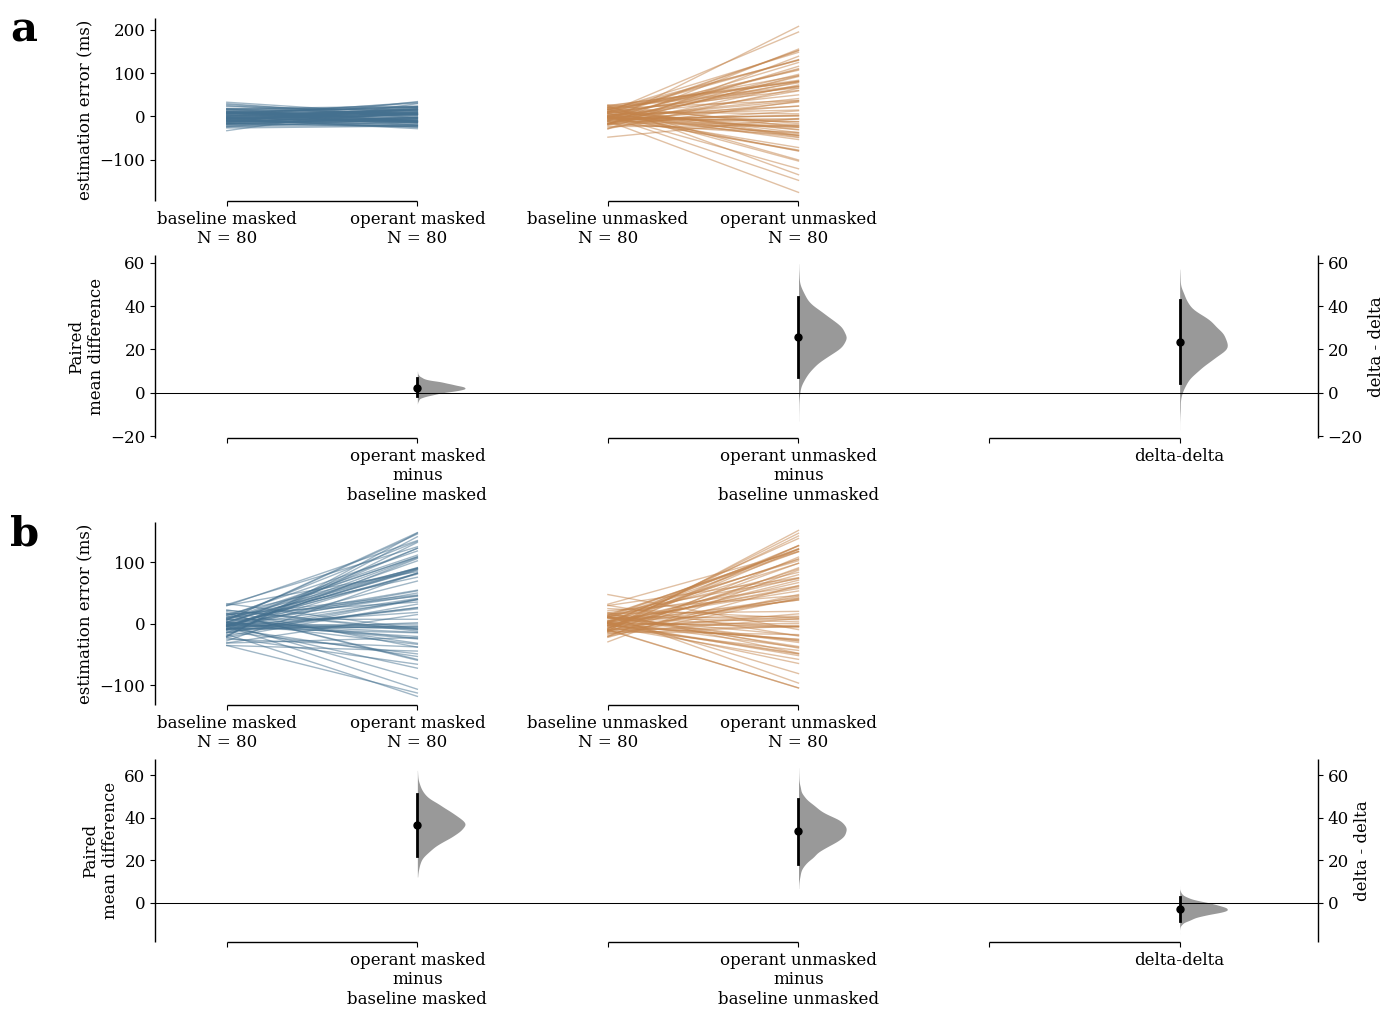

In [14]:
## and plot both null and alternative outcomes together
def add_label(ax, label):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin - .125 * xscale, ymax - .125 * yscale, 
        label, size = 30, weight = 'bold'
    )
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(2, 1, figsize = (15, 12), constrained_layout = True)

# plot null data on top
null_data.mean_diff.plot(ax = axs[0], es_marker_size = 5)
axs[0].get_legend().remove()
add_label(axs[0], 'a')

# and alternative on bottom
data.mean_diff.plot(ax = axs[1], es_marker_size = 5)
axs[1].get_legend().remove()
add_label(axs[1], 'b')

if not os.path.exists('figures'):
    os.mkdir('figures')
f = os.path.join('figures', 'hypothetical.jpeg')
plt.savefig(f, dpi = 500, bbox_inches = 'tight')
plt.show()